# Process first swath tutorial

This tutorial shows you, how to process and view elevation estimates of
a specific track. Note: cryoswath will not require you to do so. It
is designed to allow building higher level products without
augmentation. However, whenever you encounter features that seem to be
artificial, viewing the base data may help to understand what you see.

In [1]:
# make the package available/from search path
import sys
sys.path.insert(0, "..")

In [2]:
import matplotlib.pyplot as plt
import shapely
from cryoswath import misc, l2

<frozen abc>:106: FutureWarning: xarray subclass L1bData should explicitly define __slots__


Think of your favorite glacier and enter its lat, lon coordinates below.
Mind that you need to have a reference elevation model for the glacier -
so choose one that is covered.  

The code below will find the glaciers RGI identifier, load its outlines,
and than load all tracks within a 5 km radius.

In the example, I chose a point on Barnes Ice Cap.

In [3]:
lat_lon_tuple = (70.2, -73.5)
basin_rgi_id = misc.find_region_id(lat_lon_tuple, scope="basin")

In [4]:
basin_outlines = misc.load_basins([basin_rgi_id]).unary_union

/tmp/ipykernel_142892/2610810992.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  basin_outlines = misc.load_basins([basin_rgi_id]).unary_union


In [5]:
example_tracks = misc.load_cs_ground_tracks(basin_outlines, buffer_region_by=5_000)
print("number of tracks:", example_tracks.shape[0], "\n last five:", example_tracks.tail(5))

number of tracks: 481 
 last five:                                                               geometry
index                                                                 
2024-03-27 10:20:50  LINESTRING (-72.99846 72.39527, -75.93227 63.5...
2024-04-15 20:35:26  LINESTRING (-71.3213 62.41062, -74.92085 73.22...
2024-04-19 09:09:23  LINESTRING (-72.20882 72.3474, -75.11424 63.5472)
2024-04-21 09:07:26  LINESTRING (-73.15605 72.48043, -75.286 66.65353)
2024-05-08 19:23:55  LINESTRING (-70.45636 62.13489, -73.77609 72.5...


In the following, the latest track is loaded and processed.

In [6]:
swath_data, poca_data = l2.from_id(misc.cs_time_to_id(example_tracks.iloc[-1].name), drop_outside=5_000)

[note] You can speed up processing substantially by previously downloading the L1b data.
start processing 2024-05-01 00:00:00
getting 2024-05-08 19:23:55


/home/jan/Documents/PhD/projects/2023__cryoswath/scripts/../cryoswath/misc.py:909: UserWarning: Dropping 5600 glaciers < 1 km² from RGI o1 region.
  warnings.warn(f"Dropping {sum(small_glacier_mask)} glaciers < 1 km² from RGI o1 region.")
/home/jan/Documents/PhD/projects/2023__cryoswath/scripts/../cryoswath/misc.py:909: UserWarning: Dropping 5600 glaciers < 1 km² from RGI o1 region.
  warnings.warn(f"Dropping {sum(small_glacier_mask)} glaciers < 1 km² from RGI o1 region.")
/home/jan/Documents/PhD/projects/2023__cryoswath/scripts/../cryoswath/misc.py:909: UserWarning: Dropping 5600 glaciers < 1 km² from RGI o1 region.
  warnings.warn(f"Dropping {sum(small_glacier_mask)} glaciers < 1 km² from RGI o1 region.")
/home/jan/Software/miniforge3/envs/cryoswath/lib/python3.12/site-packages/xarray/core/computation.py:831: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


saving 2024-05-08 19:23:55
done processing 2024-05-01 00:00:00


The output is returned as `geopandas.GeoDataFrame`. By default, the
elevation estimates "height", the reference elevation at this location
"h_ref", and their difference "h_diff" are returned. However, by passing
the keyword arguments `out_vars` or `retain_vars`, you can freely select
what values are returned. Further, by passing `max_elev_diff` you can
discard points with large "h_diff" values. This you should do in the
production phase, but not necessarily when you evaluate your setup.
Don't worry about off-glacier points that show a large deviation.

In [7]:
swath_data

height       h_ref     h_diff  \
time                                sample                                      
2024-05-08 19:26:34.770012928+00:00 458     413.540347  405.703125   7.837222   
                                    459     413.379046  405.703125   7.675921   
                                    462     412.827374  408.789062   4.038312   
                                    463     412.349291  405.703125   6.646166   
                                    464     411.718274  410.406250   1.312024   
...                                                ...         ...        ...   
2024-05-08 19:27:10.041869056+00:00 1017    -17.875674    0.882812 -18.758487   
                                    1018    -25.463737    1.617188 -27.080925   
                                    1019    -25.276084    1.554688 -26.830772   
                                    1020    -21.759573    0.875000 -22.634573   
                                    1021    -21.917882    0.867188 -22.785069   

                                                                     geometry  
time                                sample                                     
2024-05-08 19:26:34.770012928+00:00 458     POINT (-1037014.502 -1983671.221)  
                                    459     POINT (-1037057.954 -1983655.059)  
                                    462     POINT (-1037142.338 -1983623.673)  
                                    463     POINT (-1037002.234 -1983675.784)  
                                    464     POINT (-1036711.871 -1983783.781)  
...                                                                       ...  
2024-05-08 19:27:10.041869056+00:00 1017      POINT (-949511.79 -1762645.119)  
                                    1018     POINT (-951526.527 -1761882.919)  
                                    1019     POINT (-953852.027 -1761002.998)  
                                    1020       POINT (-950167.79 -1762396.96)  
                                    1021      POINT (-950150.08 -1762403.659)  

[221323 rows x 4 columns]

In [8]:
o1_complexes = misc.load_glacier_outlines(misc.find_region_id(lat_lon_tuple, "o1"), union=False)
barnes_ice_cap_shp = o1_complexes[o1_complexes.contains(shapely.Point(lat_lon_tuple[::-1]))]

/home/jan/Documents/PhD/projects/2023__cryoswath/scripts/../cryoswath/misc.py:909: UserWarning: Dropping 5600 glaciers < 1 km² from RGI o1 region.
  warnings.warn(f"Dropping {sum(small_glacier_mask)} glaciers < 1 km² from RGI o1 region.")


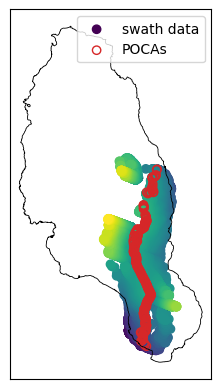

In [9]:
fig, ax = plt.subplots()
barnes_ice_cap_shp.boundary.to_crs(swath_data.crs).plot(ax=ax, color="k", lw=.6)
swath_data.clip(barnes_ice_cap_shp.geometry.to_crs(swath_data.crs)).sort_values("height").plot(column="height", ax=ax, label="swath data")
poca_data.clip(barnes_ice_cap_shp.geometry.to_crs(swath_data.crs)).plot(color="tab:red", marker="o", fc="none", ax=ax, label="POCAs")
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)
plt.legend()

You now know, how to retrieve all elevation estimates of a certain
track. Infact, you could already use a simple loop to get the elevation
estimates of all tracks. However, since that is a standard use-case,
there are dedicated pipelines to do so.